# Theory
I try out stuff from papers covering trapped BEC Theory. This is me just trying to practically "get a feel" of the various parameters involved in trapped BEC theory. 

Reference Paper:
* Dalfovo, F., Giorgini, S., Pitaevskiĭ, L.P., Pitaevskiĭ, L.P., & Stringari, S. (1998). Theory of Bose-Einstein condensation in trapped gases. Reviews of Modern Physics, 71, 463-512. https://journals.aps.org/rmp/abstract/10.1103/RevModPhys.71.463


In [1]:
from oqtant.schemas.quantum_matter import QuantumMatterFactory
from oqtant.schemas.quantum_matter import QuantumMatter as qm
from oqtant.schemas.output import Gaussian_dist_2D
from copy import deepcopy
import numpy as np
import matplotlib.pyplot as plt
from scipy.ndimage import gaussian_filter
import scipy.optimize as opt
from IPython.display import HTML

qmf = QuantumMatterFactory()
qmf.get_login()

Auth(children=(HBox(children=(Image(value=b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\x02\x12\x00\x00\x00\xc…

In [2]:
qmf.get_client()

Job Limits:
╒═══════════════╤═══════════════════╤════════════════════╤════════════════════╕
│   Daily Limit │   Daily Remaining │   Standard Credits │   Priority Credits │
╞═══════════════╪═══════════════════╪════════════════════╪════════════════════╡
│           100 │               100 │                100 │                 38 │
╘═══════════════╧═══════════════════╧════════════════════╧════════════════════╛


In [4]:
matters_it = []
temp = 50  # nK - desired cloud temperature.


In [5]:
# Create a quantum matter object with NO barrier for establishing a baseline BEC distribution
matter_baseline = qmf.create_quantum_matter(
    temperature=temp,
    lifetime=1,
    image="IN_TRAP",
    name="Theory #1: no barrier",
)

matters_it.append(matter_baseline)

In [6]:
matter_tof = qmf.create_quantum_matter(
    temperature=temp,
    lifetime=1,
    image="TIME_OF_FLIGHT",
    name="Theory #1: TOF image for atom number",
)

matters_it.append(matter_tof)

In [7]:
submission = [matter.submit(track=True) for matter in matters_it]

Submitting 1 job(s):

- Job: Theory #1: no barrier
  Job ID: 1bf2825e-aaa0-468f-9119-751cc5afd00e

Tracking 1 job(s):

- Job: Theory #1: no barrier
  - RUNNING
  - COMPLETE

All job(s) complete
Submitting 1 job(s):

- Job: Theory #1: TOF image for atom number
  Job ID: 408936a1-43c0-4905-9300-962a6e2377a5

Tracking 1 job(s):

- Job: Theory #1: TOF image for atom number
  - RUNNING
  - COMPLETE

All job(s) complete


### Harmonic Oscillator Length
First the geometric mean of the oscillators. On oqtant the oscillator frequencies are (reportedly)
$$ \omega_z = 40 Hz$$

$$\omega_x = \omega_y = 380 Hz $$

Then the geometric mean 
$$ \omega_{ho} = \left(\omega_x \omega_y \omega_z\right)^{1/3} $$

And the arithmetic mean
$$ \overline{\omega} = \left(\omega_x + \omega_y + \omega_z\right)/3 $$

Then the harmonic oscillator length
$$ a_{ho} = \left(\frac{\hbar}{m\omega_{ho}}\right)^{1/2} $$


In [7]:
omz = 40
omx = omy = 380
omho = (omx*omy*omz)**(1/3)
ombar = (omx+omy+omz)/3

hbar = 1.055e-34  # reduced Plank's constant
m = 1.443e-25  # mass of Rubidium 87

aho = (hbar/(m*omho))**(1/2)

print("geometric mean: ", omho, "Hz")
print("arithmetic mean: ", ombar, "Hz")
print("harmonic oscillator length: ", aho, "m")


geometric mean:  179.42201436929966 Hz
arithmetic mean:  266.6666666666667 Hz
harmonic oscillator length:  2.0186229206147644e-06 m


### Axial symmetry
Axial frequency
$$\omega_z$$
Radial frequency
$$\omega_{\perp} = (\omega_x^{2} + \omega_y^{2})^{1/2}$$
Ratio between radial and axial frequencies
$$\lambda = \frac{\omega_z}{\omega_{\perp}}$$
For $\lambda < 1$ the trap is cigar shaped while for $\lambda > 1$  it is disk shaped.

Thus the shape of the expanded cloud in the $xz$ plane is an ellipse, the ratio between the two axis (aspect ratio) being equal to $\sqrt{\lambda}$

In [13]:
omperp = (omx**2 + omy**2)**(1/2)
lda = omz/omperp
assratio = (lda)**(1/2)
if lda < 1:
    print("lambda =", lda, "-> cigar shape")
else:
    print("lambda =", lda, " -> disk shape")
print("aspect ratio:", assratio)

lambda = 0.07443229275647868 -> cigar shape
aspect ratio: 0.27282282301244276


In [8]:
# Get baseline data from the job without a barrier
matter_baseline.get_result()
im_baseline = matter_baseline.output.get_image_data()

Fit parameters: 
Sigma-x = 10.5 um
Sigma-y = 1.3 um
Peak optical depth = 1.38


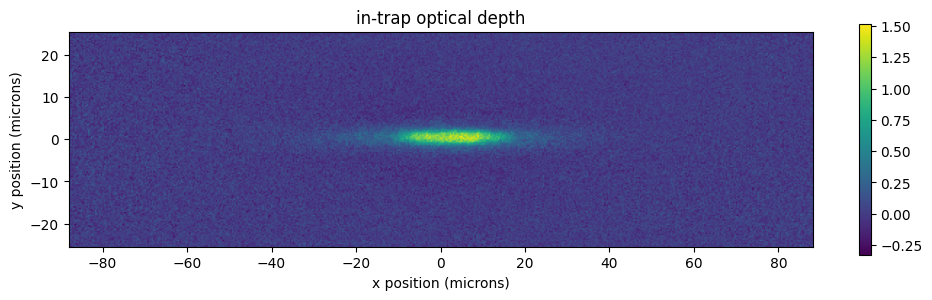

In [9]:
rows, cols = im_baseline.shape

pixcal = matter_baseline.output.it_plot.pixcal

x = np.linspace(-pixcal * cols / 2, pixcal * cols / 2, cols)
y = np.linspace(-pixcal * rows / 2, pixcal * rows / 2, rows)
xg, yg = np.meshgrid(x, y)

# Fit the experimental image to a 2D Gaussian function (imported at the beginning of the notebook)
# Order of imputs in Guassian_dist_2D (after the x-y meshgrid):
# amplitude, x_center, y_center, sigma_x, sigma_y, offset
initial_guess = [
    1,
    0,
    0,
    10,
    2,
    0,
]  # Initial 2D Gaussian parameters guess for the in-trap atom cloud size
bl = [0.3, -10, -10, 4, 0.5, -0.2]  # Lower bound for the parameters during fitting
bu = [3, 10, 10, 20, 5, 0.2]  # Upper bound for the parameters during fitting

popt, _ = opt.curve_fit(
    Gaussian_dist_2D, (xg, yg), im_baseline.ravel(), p0=initial_guess, bounds=(bl, bu)
)

# Print some of the fit parameters
sigma_x, sigma_y = (popt[3], popt[4])

print("Fit parameters: ")
print(f"Sigma-x = {sigma_x:.1f} um")
print(f"Sigma-y = {sigma_y:.1f} um")
print(f"Peak optical depth = {popt[0]:.2f}")

# Plot the experimental image
matter_baseline.output.plot_it()

### Critical Temperature and Condensate Fraction


Condensed atom number: 9738
thermal atom population: 19480
temperature (nK): 126


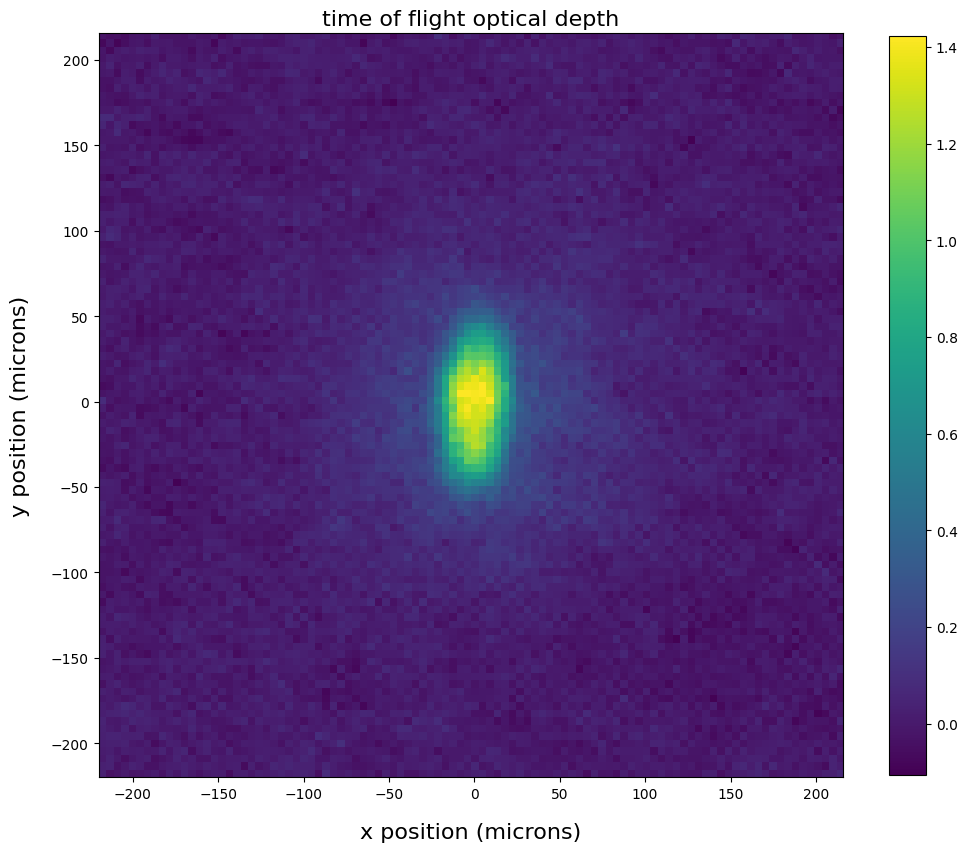

In [12]:
matter_tof.get_result()
N_atoms = matter_tof.output.condensed_atom_number
print(f"Condensed atom number: {N_atoms:.0f}")
print("thermal atom population:", matter_tof.output.thermal_atom_number)
print("temperature (nK):", matter_tof.output.temperature_nk)
matter_tof.output.plot_tof()

In [11]:
# Define constants, all in SI units
hbar = 1.055e-34  # reduced Plank's constant
m = 1.443e-25  # mass of Rubidium 87
a_s = 95 * 0.529e-10  # the scattering length of rubidium-87

# Calculate the peak atom density
V = 4 / 3 * np.pi * (1e-6 * sigma_x) * (1e-6 * sigma_y) ** 2  # units of meters^3
U = 4 * np.pi * hbar**2 * a_s / m
average_density = N_atoms / V
peak_density = 2 * average_density
print(f"Peak atom number density in-trap: {1e-6*peak_density:.1E} 1/cm^3")

# Calculate the speed of sound
v_s = np.sqrt(peak_density * U / m / 2)
print(f"Speed of sound in BEC: {1e3 * v_s:.2f} mm/s")

Peak atom number density in-trap: 2.5E+14 1/cm^3
Speed of sound in BEC: 2.05 mm/s
